# NAS Post-Mortem Analysis

Analysis of 100 NEAT hyperparameter search trials from `results/search_neat-full_20260129_190418/`.

**Search Configuration:**
- Trials: 100
- Seeds per trial: 3 (42, 123, 456)
- Generations: 150 max (early stopping at 50 gens stagnation)
- Population: 200

**Best Trial:** #68 with mean_best_fitness = 441.17

In [11]:
# Cell 1: Setup & Imports
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

results_dir = Path("results/search_neat-full_20260129_190418")
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print(f"Results directory: {results_dir}")
print(f"Exists: {results_dir.exists()}")

Results directory: results/search_neat-full_20260129_190418
Exists: True


In [12]:
# Cell 2: Data Cleanup (Section a)
# Fix pruning bug that caused extra fitness entries in some trials

print("Checking trial data for pruning issues...")
fixed_count = 0

for trial_file in sorted(results_dir.glob("trial_*.json")):
    with open(trial_file) as f:
        data = json.load(f)
    
    seeds = data['seeds']
    num_seeds = len(seeds)
    best = data['best_fitness_per_seed']
    avg = data['avg_fitness_per_seed']

    needs_fix = len(best) != num_seeds or any(b == 0 for b in best) or any(a == 0 for a in avg)
    if needs_fix:
        # Remove zero entries wherever they appear (keep relative order)
        cleaned_pairs = [(b, a) for b, a in zip(best, avg) if b != 0 and a != 0]
        best = [b for b, _ in cleaned_pairs]
        avg = [a for _, a in cleaned_pairs]

        # If still too long, truncate to seed count
        if len(best) > num_seeds:
            best = best[:num_seeds]
            avg = avg[:num_seeds]

        # Recalculate means
        data['best_fitness_per_seed'] = best
        data['avg_fitness_per_seed'] = avg
        data['mean_best_fitness'] = sum(best) / len(best) if best else 0
        data['mean_avg_fitness'] = sum(avg) / len(avg) if avg else 0

        # Save
        with open(trial_file, 'w') as f:
            json.dump(data, f, indent=2)

        print(f"  Fixed {trial_file.name}")
        if len(best) != num_seeds:
            print(f"    Warning: {trial_file.name} has {len(best)} entries for {num_seeds} seeds")
        fixed_count += 1

print(f"\nCleaned {fixed_count} trials")

Checking trial data for pruning issues...

Cleaned 0 trials


In [13]:
# Cell 3: Load All Data (Section b)

# Load summary
with open(results_dir / "summary.json") as f:
    summary = json.load(f)

# Load all trial results
trials = []
for f in sorted(results_dir.glob("trial_*.json")):
    with open(f) as file:
        trials.append(json.load(file))

print(f"Loaded {len(trials)} trials")
print(f"Best trial from summary: #{summary['best_trial']} with fitness {summary['best_value']:.2f}")

# Convert to DataFrame
df = pd.DataFrame([{
    'trial': t['trial_number'],
    'mean_best': t['mean_best_fitness'],
    'mean_avg': t['mean_avg_fitness'],
    'generations': t.get('generations', 150),
    **t['params']
} for t in trials])

# Store raw trial data for seed-level analysis
trials_raw = trials

print(f"\nDataFrame shape: {df.shape}")
print(f"\nTop 5 trials by mean_best:")
display(df.nlargest(5, 'mean_best')[['trial', 'mean_best', 'mean_avg']])

Loaded 100 trials
Best trial from summary: #68 with fitness 441.17

DataFrame shape: (100, 34)

Top 5 trials by mean_best:


,trial,mean_best,mean_avg
68,68,441.170003,27.094428
57,57,439.475840,27.641897
90,90,439.207011,24.994274
63,63,425.487508,27.211281
66,66,424.042765,29.114890


## Overview: Fitness Distribution & Seed Variance

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/2238234923.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([df['mean_best'], df['mean_avg']], labels=['Best', 'Avg'], patch_artist=True)


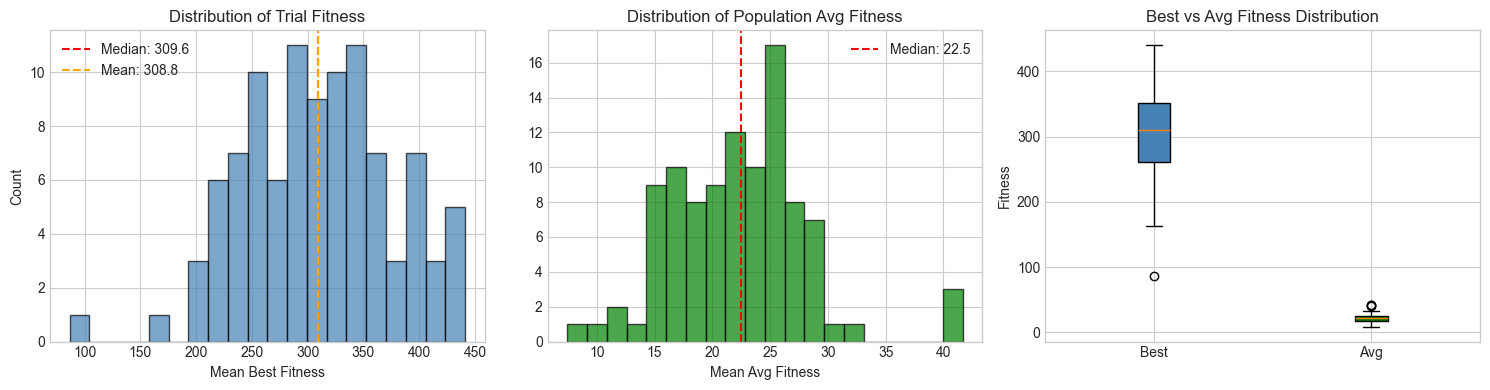

Summary Statistics:
  Mean Best:  mean=308.8, median=309.6, std=67.3
  Mean Avg:   mean=22.3, median=22.5, std=5.9
  Fitness range: 86.5 - 441.2


In [14]:
# Fitness Distribution Histogram & Basic Stats

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of mean_best fitness
ax = axes[0]
ax.hist(df['mean_best'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df['mean_best'].median(), color='red', linestyle='--', label=f'Median: {df["mean_best"].median():.1f}')
ax.axvline(df['mean_best'].mean(), color='orange', linestyle='--', label=f'Mean: {df["mean_best"].mean():.1f}')
ax.set_xlabel('Mean Best Fitness')
ax.set_ylabel('Count')
ax.set_title('Distribution of Trial Fitness')
ax.legend()

# Histogram of mean_avg fitness
ax = axes[1]
ax.hist(df['mean_avg'], bins=20, edgecolor='black', alpha=0.7, color='green')
ax.axvline(df['mean_avg'].median(), color='red', linestyle='--', label=f'Median: {df["mean_avg"].median():.1f}')
ax.set_xlabel('Mean Avg Fitness')
ax.set_title('Distribution of Population Avg Fitness')
ax.legend()

# Box plot comparing best vs avg
ax = axes[2]
bp = ax.boxplot([df['mean_best'], df['mean_avg']], labels=['Best', 'Avg'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('green')
ax.set_ylabel('Fitness')
ax.set_title('Best vs Avg Fitness Distribution')

plt.tight_layout()
plt.show()

# Summary stats
print("Summary Statistics:")
print(f"  Mean Best:  mean={df['mean_best'].mean():.1f}, median={df['mean_best'].median():.1f}, std={df['mean_best'].std():.1f}")
print(f"  Mean Avg:   mean={df['mean_avg'].mean():.1f}, median={df['mean_avg'].median():.1f}, std={df['mean_avg'].std():.1f}")
print(f"  Fitness range: {df['mean_best'].min():.1f} - {df['mean_best'].max():.1f}")

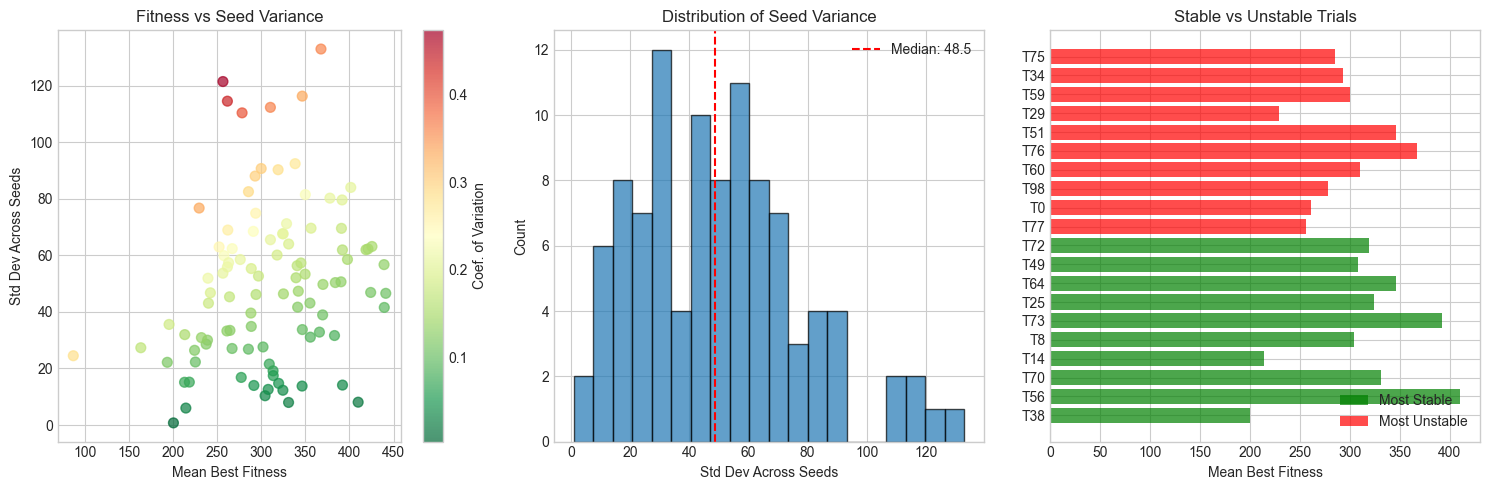


Seed Variance Insights:
  Median std dev across seeds: 48.5
  Median CV: 0.149


In [15]:
# Seed Variance Analysis - How consistent are configs across different random seeds?

# Calculate per-trial variance across seeds
seed_stats = []
for t in trials_raw:
    best_per_seed = t['best_fitness_per_seed']
    seed_stats.append({
        'trial': t['trial_number'],
        'mean_best': t['mean_best_fitness'],
        'best_std': np.std(best_per_seed) if len(best_per_seed) > 1 else 0,
        'best_cv': np.std(best_per_seed) / (np.mean(best_per_seed) + 1e-6) if len(best_per_seed) > 1 else 0,
        'seeds': best_per_seed
    })

seed_df = pd.DataFrame(seed_stats)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Scatter: mean fitness vs std across seeds
ax = axes[0]
scatter = ax.scatter(seed_df['mean_best'], seed_df['best_std'], 
                     c=seed_df['best_cv'], cmap='RdYlGn_r', alpha=0.7, s=50)
plt.colorbar(scatter, ax=ax, label='Coef. of Variation')
ax.set_xlabel('Mean Best Fitness')
ax.set_ylabel('Std Dev Across Seeds')
ax.set_title('Fitness vs Seed Variance')

# 2. Distribution of seed variance
ax = axes[1]
ax.hist(seed_df['best_std'], bins=20, edgecolor='black', alpha=0.7)
ax.axvline(seed_df['best_std'].median(), color='red', linestyle='--', 
           label=f'Median: {seed_df["best_std"].median():.1f}')
ax.set_xlabel('Std Dev Across Seeds')
ax.set_ylabel('Count')
ax.set_title('Distribution of Seed Variance')
ax.legend()

# 3. Most stable vs unstable
ax = axes[2]
most_stable = seed_df.nsmallest(10, 'best_cv')
most_unstable = seed_df.nlargest(10, 'best_cv')
y_pos = range(20)
ax.barh(y_pos[:10], most_stable['mean_best'].values, alpha=0.7, label='Most Stable', color='green')
ax.barh(y_pos[10:], most_unstable['mean_best'].values, alpha=0.7, label='Most Unstable', color='red')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"T{int(t)}" for t in most_stable['trial']] + 
                   [f"T{int(t)}" for t in most_unstable['trial']])
ax.set_xlabel('Mean Best Fitness')
ax.set_title('Stable vs Unstable Trials')
ax.legend()

plt.tight_layout()
plt.show()

print("\nSeed Variance Insights:")
print(f"  Median std dev across seeds: {seed_df['best_std'].median():.1f}")
print(f"  Median CV: {seed_df['best_cv'].median():.3f}")

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/3290507676.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([full], labels=['Full 150'], patch_artist=True)


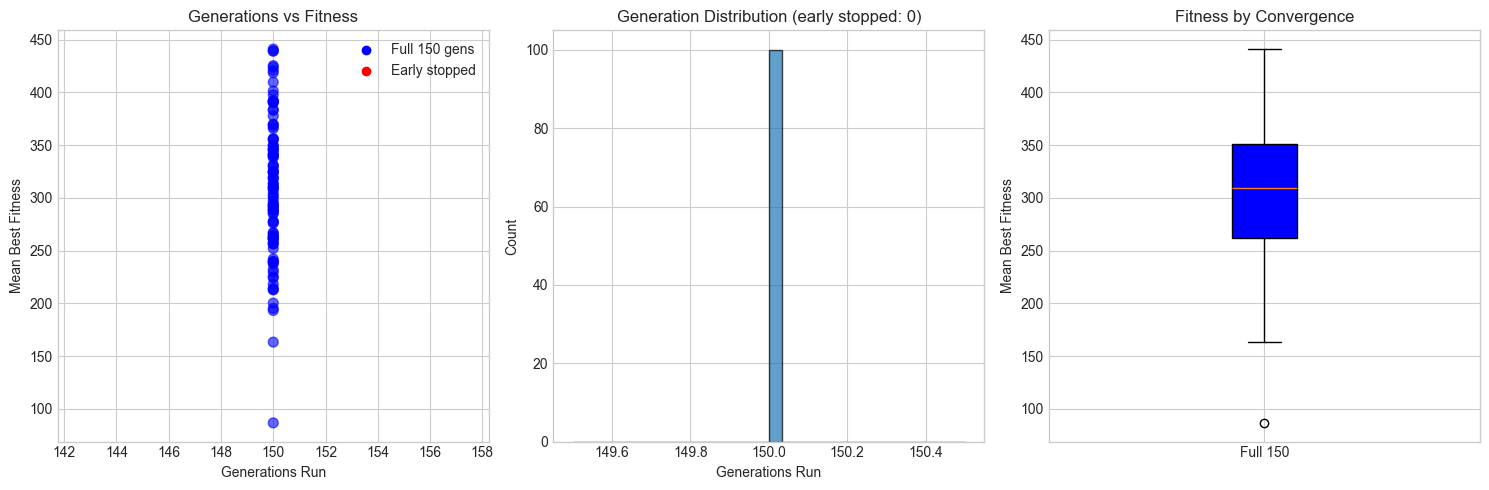


Convergence: 100 full runs, 0 early-stopped


In [16]:
# Early Stopping / Convergence Analysis

df['early_stopped'] = df['generations'] < 150

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Generations run vs fitness
ax = axes[0]
colors = ['red' if es else 'blue' for es in df['early_stopped']]
ax.scatter(df['generations'], df['mean_best'], c=colors, alpha=0.6, s=50)
ax.set_xlabel('Generations Run')
ax.set_ylabel('Mean Best Fitness')
ax.set_title('Generations vs Fitness')
ax.scatter([], [], c='blue', label='Full 150 gens')
ax.scatter([], [], c='red', label='Early stopped')
ax.legend()

# 2. Distribution of generations
ax = axes[1]
ax.hist(df['generations'], bins=30, edgecolor='black', alpha=0.7)
ax.set_xlabel('Generations Run')
ax.set_ylabel('Count')
ax.set_title(f'Generation Distribution (early stopped: {df["early_stopped"].sum()})')

# 3. Box plot comparison
ax = axes[2]
early = df[df['early_stopped']]['mean_best'].values
full = df[~df['early_stopped']]['mean_best'].values
if len(early) > 0:
    bp = ax.boxplot([full, early], labels=['Full 150', 'Early stopped'], patch_artist=True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('red')
else:
    bp = ax.boxplot([full], labels=['Full 150'], patch_artist=True)
    bp['boxes'][0].set_facecolor('blue')
ax.set_ylabel('Mean Best Fitness')
ax.set_title('Fitness by Convergence')

plt.tight_layout()
plt.show()

print(f"\nConvergence: {(~df['early_stopped']).sum()} full runs, {df['early_stopped'].sum()} early-stopped")

In [17]:
# Best Trial Deep Dive - Compare champion params to median values

best_row = df.loc[df['mean_best'].idxmax()]
best_trial_num = int(best_row['trial'])

# Get parameter columns
param_cols = [c for c in df.columns if c not in ['trial', 'mean_best', 'mean_avg', 'generations', 
                                                   'early_stopped', 'hidden_bin', 'compat_bin',
                                                   'combined_score', 'learning_ratio', 'fitness_bin', 'z_score']]

print("=" * 70)
print(f"BEST TRIAL #{best_trial_num} - DEEP DIVE")
print("=" * 70)
print(f"Mean Best Fitness: {best_row['mean_best']:.2f}")
print(f"Mean Avg Fitness: {best_row['mean_avg']:.2f}")

print("\n" + "-" * 70)
print(f"{'Parameter':<35} {'Best':>12} {'Median':>12} {'Diff':>10}")
print("-" * 70)

for col in sorted(param_cols):
    best_val = best_row[col]
    if pd.api.types.is_numeric_dtype(df[col]):
        median_val = df[col].median()
        if isinstance(best_val, (int, float)) and not pd.isna(best_val):
            diff = best_val - median_val
            marker = " <<<" if abs(diff) > df[col].std() else ""
            print(f"{col:<35} {best_val:>12.4f} {median_val:>12.4f} {diff:>+10.3f}{marker}")
    else:
        mode_val = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else "N/A"
        match = "✓" if best_val == mode_val else "≠"
        print(f"{col:<35} {str(best_val):>12} {str(mode_val):>12} {match:>10}")

# Show per-seed values
best_raw = next(t for t in trials_raw if t['trial_number'] == best_trial_num)
print("\n" + "-" * 70)
print("Per-Seed Results:")
for seed, best_fit, avg_fit in zip(best_raw['seeds'], best_raw['best_fitness_per_seed'], best_raw['avg_fitness_per_seed']):
    print(f"  Seed {seed}: best={best_fit:.1f}, avg={avg_fit:.2f}")

BEST TRIAL #68 - DEEP DIVE
Mean Best Fitness: 441.17
Mean Avg Fitness: 27.09

----------------------------------------------------------------------
Parameter                                   Best       Median       Diff
----------------------------------------------------------------------
bias_mode                              bias_node         node          ≠
compatibility_threshold                   3.1092       3.0624     +0.047
crossover_rate                            0.2244       0.2604     -0.036
cull_percentage                           0.6884       0.7017     -0.013
mutation_magnitude                        0.4592       0.4403     +0.019
mutation_rate                             0.5264       0.4331     +0.093
neat_add_connection_rate                  0.4492       0.4431     +0.006
neat_add_node_rate                        0.2472       0.2275     +0.020
neat_disable_rate                         0.0912       0.0854     +0.006
neat_disjoint_coefficient                 0.7008  

### Overview Analysis Notes

**Fitness Distribution:**
- Mean: 308.8, Median: 309.6, Std: 67.3
- Range: 86.5 - 441.2 (5x spread between worst and best)
- Distribution is roughly normal with slight right tail

**Seed Variance:**
- Typical trial varies ~15% across seeds (CV=0.149)
- Some configurations are extremely unstable (CV up to 0.47)
- Best trial #68 is stable (CV=0.106) - results are reproducible

**Convergence:**
- All trials ran full 150 generations (no early stopping triggered)
- This suggests 50-generation stagnation limit was appropriate

## Section c: Parameter Importance Analysis

Correlation with mean_best_fitness (sorted by absolute value):
crossover_rate              -0.468242
mutation_magnitude           0.399641
max_nodes                    0.389211
min_nodes                    0.315418
mutation_rate                0.307317
neat_weight_coefficient      0.296278
neat_disable_rate            0.280444
cull_percentage              0.270951
neat_disjoint_coefficient   -0.216022
weight_mutation_rate        -0.192608
adaptive_mutation_boost      0.187766
neat_add_node_rate           0.187157
max_muscles                 -0.144437
stagnation_threshold        -0.129705
neat_max_hidden_nodes       -0.094238
neat_excess_coefficient     -0.083567
neat_add_connection_rate     0.064448
neat_enable_rate             0.057119
neural_dead_zone             0.045740
min_species_size            -0.044786
neural_output_bias           0.034132
weight_mutation_magnitude    0.032034
compatibility_threshold     -0.020188


/Users/silen/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


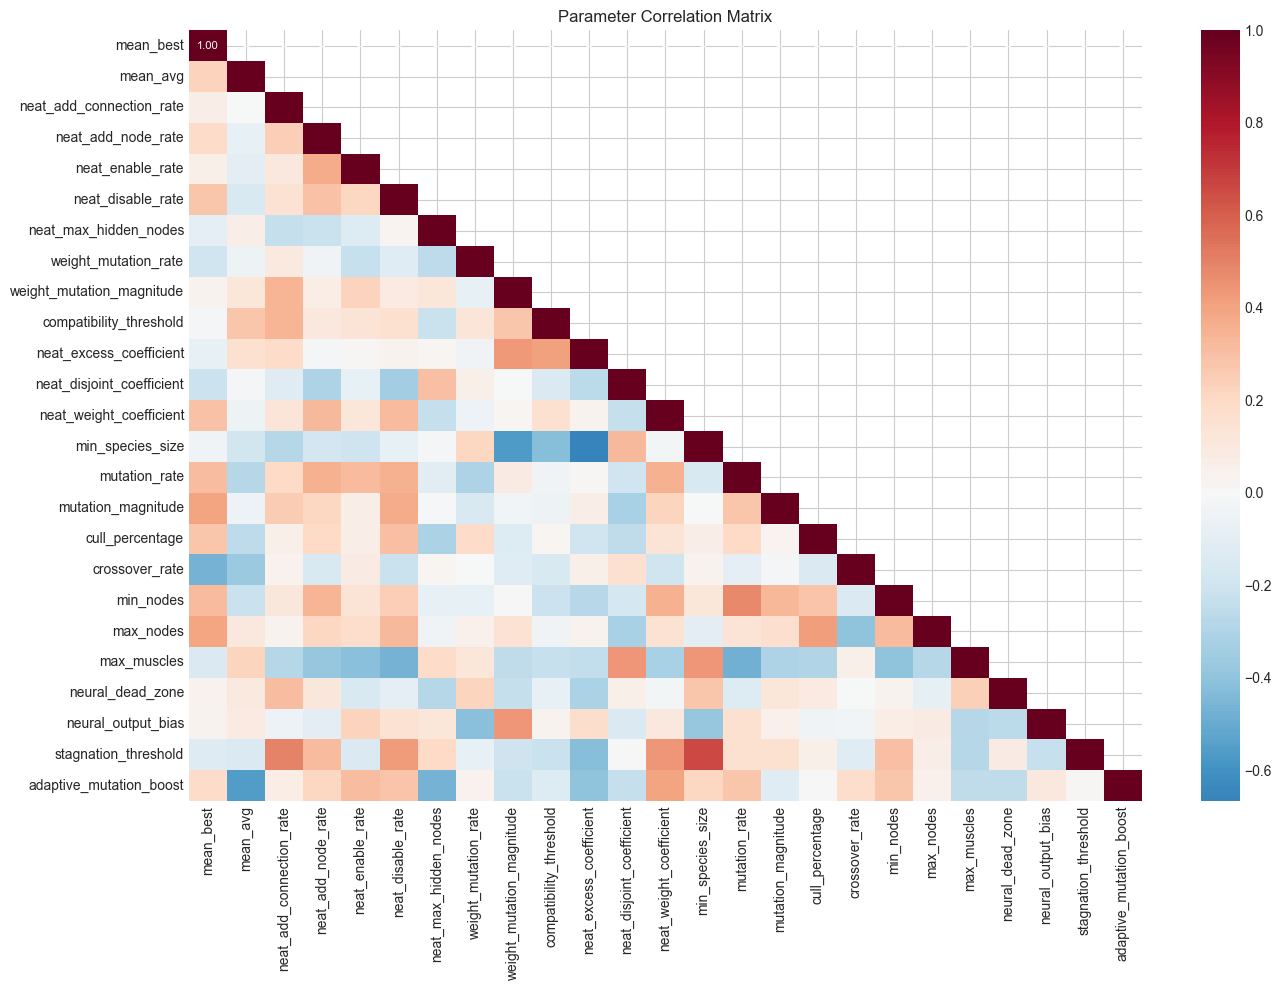

In [18]:
# Cell 4: Correlation matrix of numeric params vs mean_best_fitness

# Select numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove trial number and target variables from features
feature_cols = [c for c in numeric_cols if c not in ['trial', 'mean_best', 'mean_avg', 'generations']]

# Calculate correlations with mean_best
correlations = df[feature_cols].corrwith(df['mean_best']).sort_values(key=abs, ascending=False)

print("Correlation with mean_best_fitness (sorted by absolute value):")
print(correlations.to_string())

# Correlation heatmap
fig, ax = plt.subplots(figsize=(14, 10))
corr_matrix = df[['mean_best', 'mean_avg'] + feature_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, annot_kws={'size': 8})
plt.title('Parameter Correlation Matrix')
plt.tight_layout()
plt.show()

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/149267834.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Top 10', 'Bottom 10'], patch_artist=True)
/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/149267834.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Top 10', 'Bottom 10'], patch_artist=True)
/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/149267834.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Top 10', 'Bottom 10'], patch_artist=True

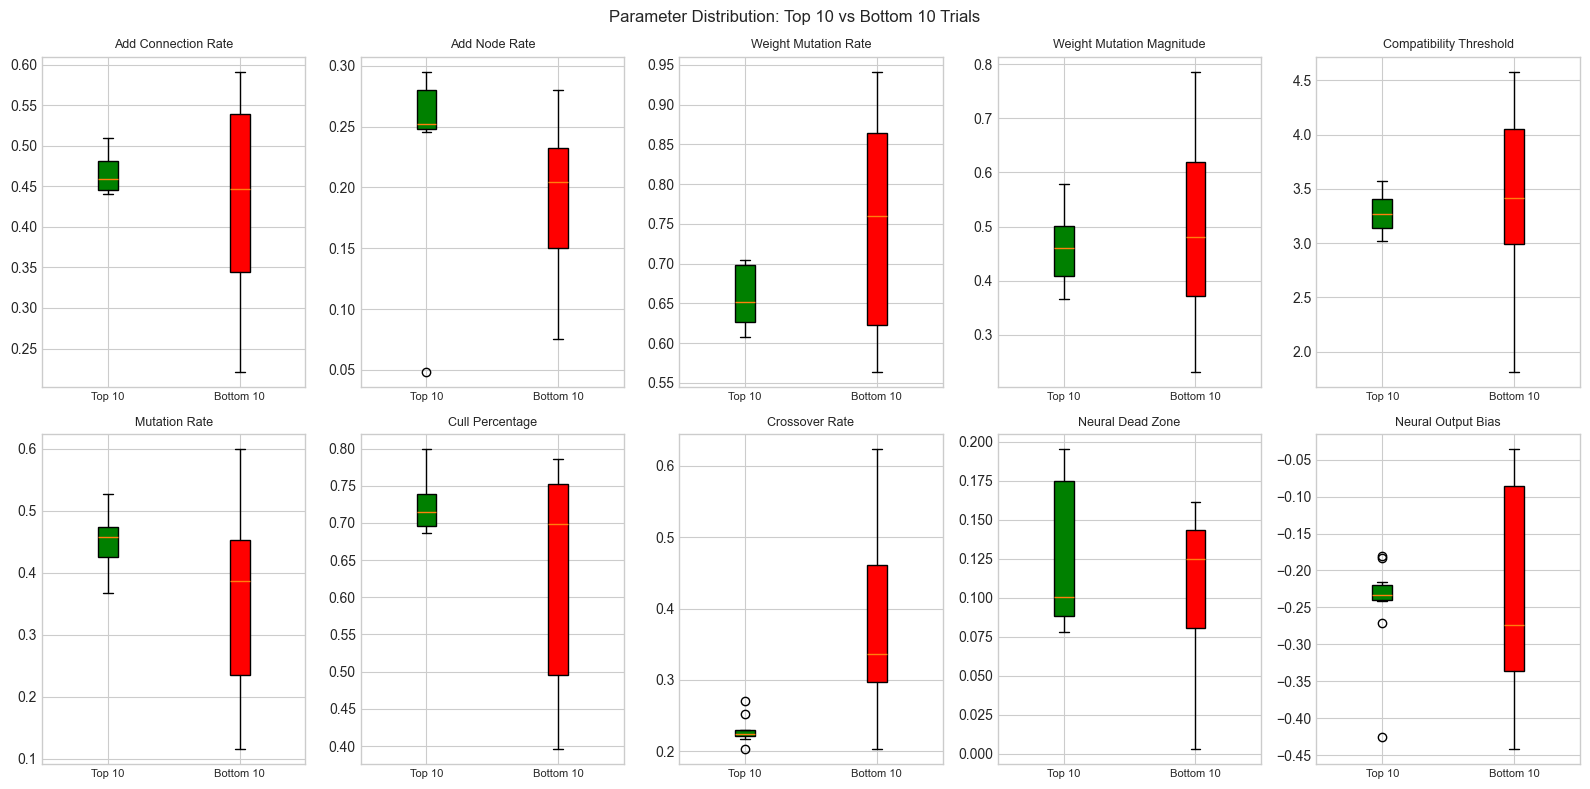

In [19]:
# Cell 5: Top/bottom 10 trials comparison for key params

# Get top and bottom trials
top_10 = df.nlargest(10, 'mean_best')
bottom_10 = df.nsmallest(10, 'mean_best')

# Key numeric parameters to compare
key_params = [
    'neat_add_connection_rate', 'neat_add_node_rate', 
    'weight_mutation_rate', 'weight_mutation_magnitude',
    'compatibility_threshold', 'mutation_rate', 
    'cull_percentage', 'crossover_rate',
    'neural_dead_zone', 'neural_output_bias'
]

# Create comparison box plots
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.flatten()

for idx, param in enumerate(key_params):
    if param in df.columns:
        ax = axes[idx]
        data_to_plot = [
            top_10[param].values,
            bottom_10[param].values
        ]
        bp = ax.boxplot(data_to_plot, labels=['Top 10', 'Bottom 10'], patch_artist=True)
        bp['boxes'][0].set_facecolor('green')
        bp['boxes'][1].set_facecolor('red')
        ax.set_title(param.replace('neat_', '').replace('_', ' ').title(), fontsize=9)
        ax.tick_params(axis='x', labelsize=8)

plt.suptitle('Parameter Distribution: Top 10 vs Bottom 10 Trials', fontsize=12)
plt.tight_layout()
plt.show()

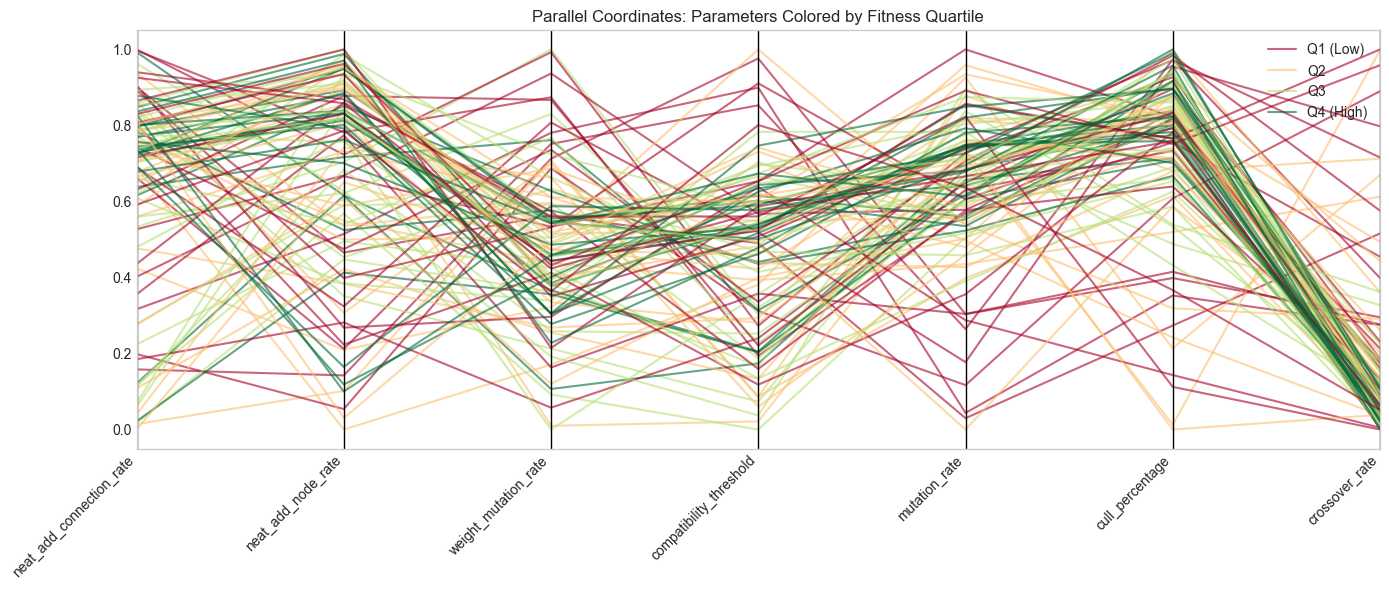

In [20]:
# Cell 6: Parallel coordinates plot

from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
plot_params = ['neat_add_connection_rate', 'neat_add_node_rate', 'weight_mutation_rate',
               'compatibility_threshold', 'mutation_rate', 'cull_percentage', 'crossover_rate']

# Normalize parameters for better visualization
df_norm = df[['trial', 'mean_best'] + plot_params].copy()
for col in plot_params:
    if col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

# Create fitness bins for coloring
df_norm['fitness_bin'] = pd.qcut(df['mean_best'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

fig, ax = plt.subplots(figsize=(14, 6))
parallel_coordinates(df_norm[plot_params + ['fitness_bin']], 'fitness_bin', 
                    colormap=plt.cm.RdYlGn, alpha=0.6, ax=ax)
plt.title('Parallel Coordinates: Parameters Colored by Fitness Quartile')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Section d: Proprioception Analysis

T-test: t=1.573, p=0.1191
Difference is not significant at p<0.05


/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/4058960224.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


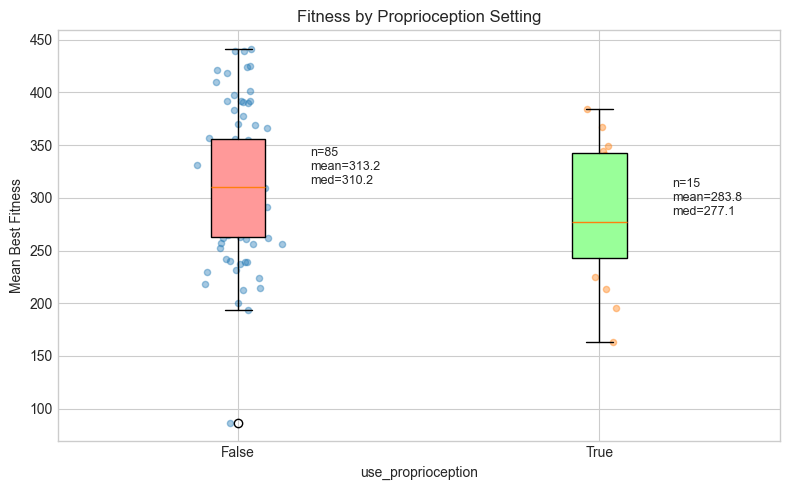

In [21]:
# Cell 7: Box plot - use_proprioception True vs False

fig, ax = plt.subplots(figsize=(8, 5))

proprio_groups = df.groupby('use_proprioception')['mean_best'].apply(list)

data = [df[df['use_proprioception'] == False]['mean_best'].values,
        df[df['use_proprioception'] == True]['mean_best'].values]
labels = ['False', 'True']

bp = ax.boxplot(data, labels=labels, patch_artist=True)
colors = ['#ff9999', '#99ff99']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points
for i, d in enumerate(data):
    x = np.random.normal(i + 1, 0.04, size=len(d))
    ax.scatter(x, d, alpha=0.4, s=20)

ax.set_xlabel('use_proprioception')
ax.set_ylabel('Mean Best Fitness')
ax.set_title('Fitness by Proprioception Setting')

# Stats
for i, label in enumerate(labels):
    vals = data[i]
    ax.annotate(f'n={len(vals)}\nmean={np.mean(vals):.1f}\nmed={np.median(vals):.1f}', 
                xy=(i + 1.2, np.mean(vals)), fontsize=9)

# T-test
if len(data[0]) > 0 and len(data[1]) > 0:
    t_stat, p_val = stats.ttest_ind(data[0], data[1])
    print(f"T-test: t={t_stat:.3f}, p={p_val:.4f}")
    significance = "significant" if p_val < 0.05 else "not significant"
    print(f"Difference is {significance} at p<0.05")

plt.tight_layout()
plt.show()

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/1918302463.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=modes, patch_artist=True)


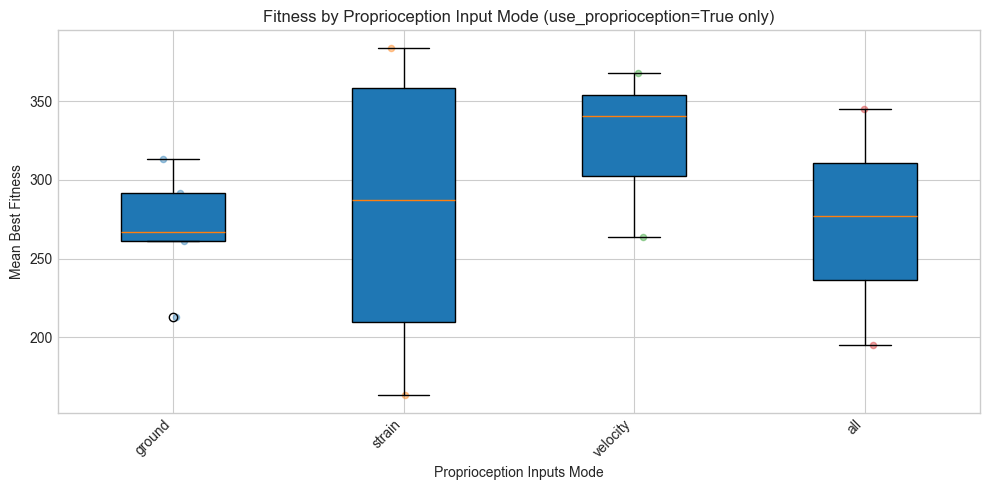


Summary by proprioception_inputs mode:
                       count        mean         std         max
proprioception_inputs                                           
all                        3  272.411819   74.933806  344.874756
ground                     5  269.227075   37.613357  313.286631
strain                     4  280.450512  103.784189  383.924052
velocity                   3  324.008859   53.842530  367.620855


In [22]:
# Cell 8: Box plot - proprioception_inputs modes (only when use_proprioception=True)

# Check if proprioception_inputs column exists
if 'proprioception_inputs' in df.columns:
    proprio_df = df[df['use_proprioception'] == True]
    
    if len(proprio_df) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        
        modes = proprio_df['proprioception_inputs'].unique()
        data = [proprio_df[proprio_df['proprioception_inputs'] == mode]['mean_best'].values for mode in modes]
        
        bp = ax.boxplot(data, labels=modes, patch_artist=True)
        
        # Add individual points
        for i, d in enumerate(data):
            if len(d) > 0:
                x = np.random.normal(i + 1, 0.04, size=len(d))
                ax.scatter(x, d, alpha=0.4, s=20)
        
        ax.set_xlabel('Proprioception Inputs Mode')
        ax.set_ylabel('Mean Best Fitness')
        ax.set_title('Fitness by Proprioception Input Mode (use_proprioception=True only)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Summary stats
        print("\nSummary by proprioception_inputs mode:")
        print(proprio_df.groupby('proprioception_inputs')['mean_best'].agg(['count', 'mean', 'std', 'max']))
    else:
        print("No trials with use_proprioception=True")
else:
    print("proprioception_inputs column not found in data")
    print(f"\nTrials with use_proprioception=True: {len(df[df['use_proprioception'] == True])}")
    print(f"Trials with use_proprioception=False: {len(df[df['use_proprioception'] == False])}")

## Section e: Network Topology Patterns

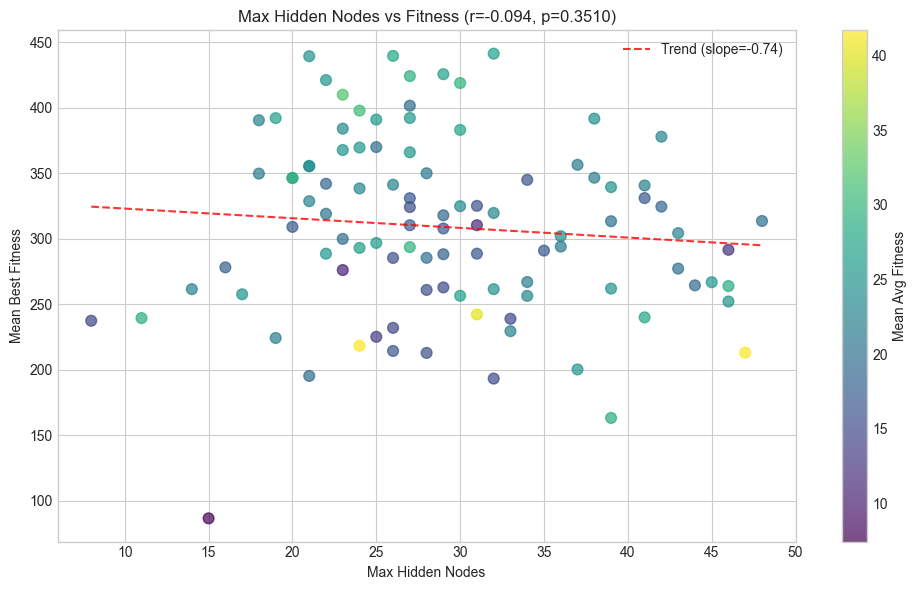


Fitness by max_hidden_nodes bins:
            count        mean        std         max
hidden_bin                                          
1-16            5  220.556682  76.776642  278.093959
17-32          65  324.999779  65.441557  441.170003
33-48          30  288.504785  53.398845  391.578959
49-64           0         NaN        NaN         NaN


/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/2530063573.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('hidden_bin')['mean_best'].agg(['count', 'mean', 'std', 'max']))


In [23]:
# Cell 9: Scatter - neat_max_hidden_nodes vs fitness

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df['neat_max_hidden_nodes'], df['mean_best'], 
                     c=df['mean_avg'], cmap='viridis', alpha=0.7, s=60)
plt.colorbar(scatter, label='Mean Avg Fitness')

# Trend line
z = np.polyfit(df['neat_max_hidden_nodes'], df['mean_best'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['neat_max_hidden_nodes'].min(), df['neat_max_hidden_nodes'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'Trend (slope={z[0]:.2f})')

# Correlation
corr, p_val = stats.pearsonr(df['neat_max_hidden_nodes'], df['mean_best'])
ax.set_xlabel('Max Hidden Nodes')
ax.set_ylabel('Mean Best Fitness')
ax.set_title(f'Max Hidden Nodes vs Fitness (r={corr:.3f}, p={p_val:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

# Stats by hidden node bins
print("\nFitness by max_hidden_nodes bins:")
df['hidden_bin'] = pd.cut(df['neat_max_hidden_nodes'], bins=[0, 16, 32, 48, 64], labels=['1-16', '17-32', '33-48', '49-64'])
print(df.groupby('hidden_bin')['mean_best'].agg(['count', 'mean', 'std', 'max']))

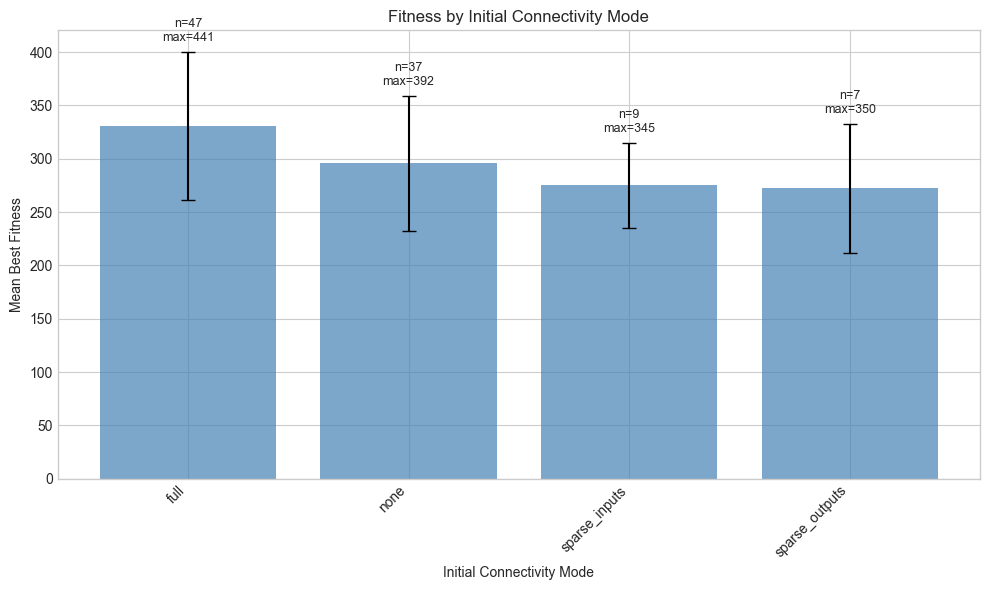


Detailed stats:
                                 mean        std  count         max
neat_initial_connectivity                                          
full                       331.001997  69.271311     47  441.170003
none                       295.836046  63.253109     37  391.578959
sparse_inputs              274.887412  40.175805      9  344.874756
sparse_outputs             272.271191  60.484185      7  349.628215


In [24]:
# Cell 10: Bar chart - neat_initial_connectivity mode vs mean fitness

fig, ax = plt.subplots(figsize=(10, 6))

connectivity_stats = df.groupby('neat_initial_connectivity')['mean_best'].agg(['mean', 'std', 'count', 'max'])
connectivity_stats = connectivity_stats.sort_values('mean', ascending=False)

x = range(len(connectivity_stats))
bars = ax.bar(x, connectivity_stats['mean'], yerr=connectivity_stats['std'], 
              capsize=5, color='steelblue', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(connectivity_stats.index, rotation=45, ha='right')
ax.set_xlabel('Initial Connectivity Mode')
ax.set_ylabel('Mean Best Fitness')
ax.set_title('Fitness by Initial Connectivity Mode')

# Add count labels on bars
for i, (idx, row) in enumerate(connectivity_stats.iterrows()):
    ax.annotate(f'n={int(row["count"])}\nmax={row["max"]:.0f}', 
                xy=(i, row['mean'] + row['std'] + 10), 
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nDetailed stats:")
print(connectivity_stats)

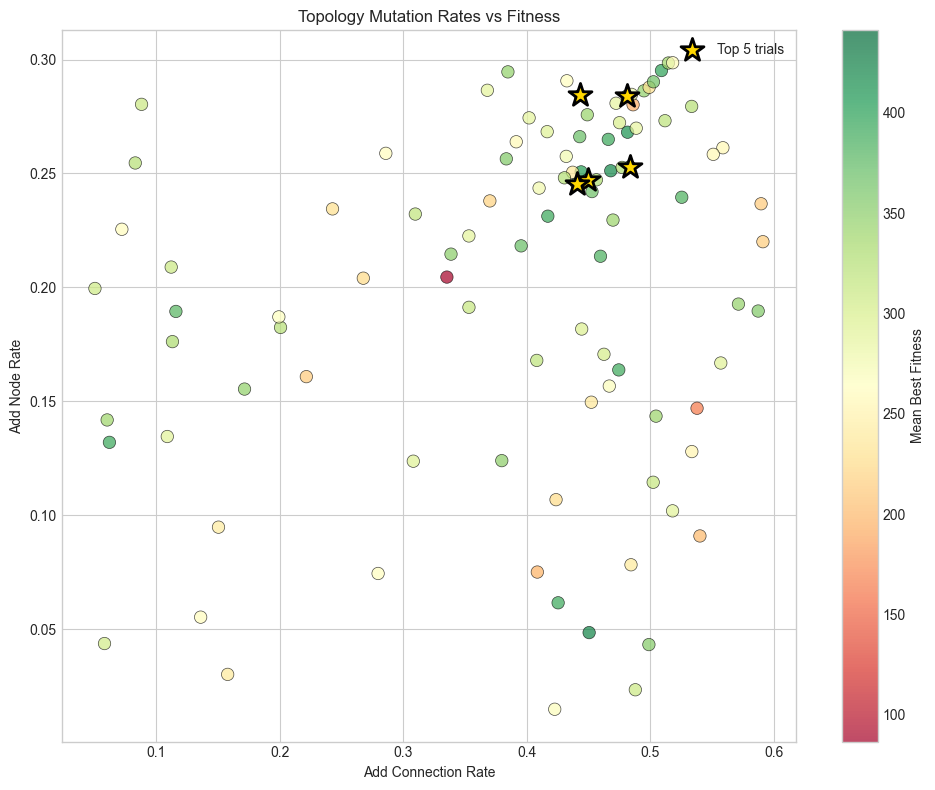


Top 10 trials - add_connection_rate and add_node_rate:
    trial   mean_best  neat_add_connection_rate  neat_add_node_rate
68     68  441.170003                  0.449231            0.247165
57     57  439.475840                  0.481346            0.284026
90     90  439.207011                  0.483497            0.252962
63     63  425.487508                  0.443233            0.284236
66     66  424.042765                  0.440345            0.245526
92     92  420.984233                  0.450544            0.048461
82     82  418.737467                  0.468050            0.251197
56     56  409.827464                  0.481692            0.268109
67     67  401.440948                  0.444093            0.250698
61     61  397.702382                  0.509132            0.295182


In [25]:
# Cell 11: Scatter - add_node_rate vs add_connection_rate (colored by fitness)

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(df['neat_add_connection_rate'], df['neat_add_node_rate'], 
                     c=df['mean_best'], cmap='RdYlGn', s=80, alpha=0.7, 
                     edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Mean Best Fitness')

# Mark top 5 trials
top_5 = df.nlargest(5, 'mean_best')
ax.scatter(top_5['neat_add_connection_rate'], top_5['neat_add_node_rate'], 
           marker='*', s=300, c='gold', edgecolors='black', linewidth=2, 
           label='Top 5 trials', zorder=5)

ax.set_xlabel('Add Connection Rate')
ax.set_ylabel('Add Node Rate')
ax.set_title('Topology Mutation Rates vs Fitness')
ax.legend()
plt.tight_layout()
plt.show()

# Print sweet spot
print("\nTop 10 trials - add_connection_rate and add_node_rate:")
print(df.nlargest(10, 'mean_best')[['trial', 'mean_best', 'neat_add_connection_rate', 'neat_add_node_rate']])

## Section f: NEAT-Specific Settings

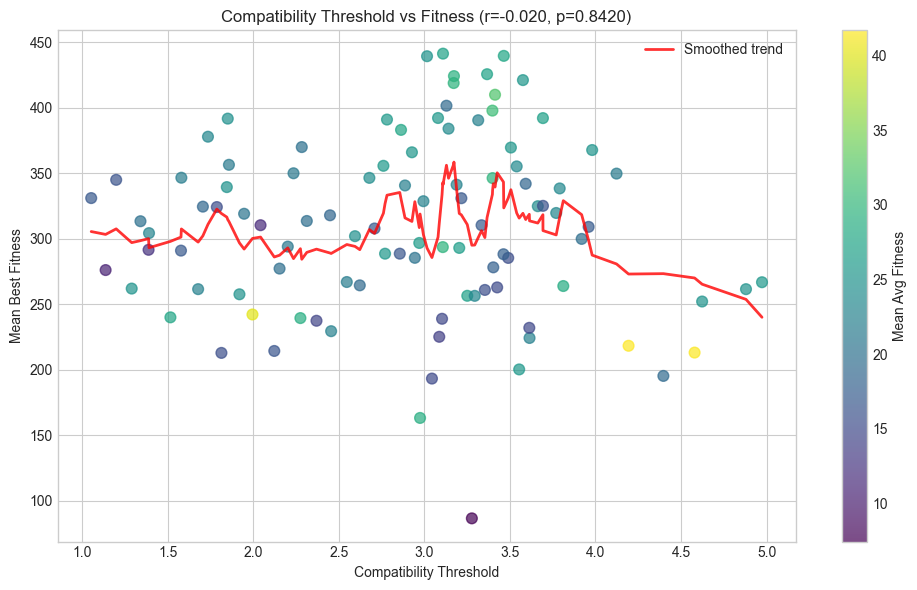


Fitness by compatibility_threshold bins:
                count        mean        std         max
compat_bin                                              
(1.05, 1.837]      15  300.034482  44.268258  377.784414
(1.837, 2.621]     19  296.176338  51.596000  391.578959
(2.621, 3.405]     38  321.830551  79.661417  441.170003
(3.405, 4.189]     22  323.581258  63.847224  439.475840
(4.189, 4.973]      6  234.449382  29.457870  266.733922


/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/1851299956.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('compat_bin')['mean_best'].agg(['count', 'mean', 'std', 'max']))


In [26]:
# Cell 12: Scatter - compatibility_threshold vs fitness

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df['compatibility_threshold'], df['mean_best'], 
                     c=df['mean_avg'], cmap='viridis', alpha=0.7, s=60)
plt.colorbar(scatter, label='Mean Avg Fitness')

# LOWESS smoothing for trend
from scipy.ndimage import uniform_filter1d
sorted_idx = df['compatibility_threshold'].argsort()
x_sorted = df['compatibility_threshold'].values[sorted_idx]
y_sorted = df['mean_best'].values[sorted_idx]
y_smooth = uniform_filter1d(y_sorted, size=10)
ax.plot(x_sorted, y_smooth, 'r-', linewidth=2, alpha=0.8, label='Smoothed trend')

# Correlation
corr, p_val = stats.pearsonr(df['compatibility_threshold'], df['mean_best'])
ax.set_xlabel('Compatibility Threshold')
ax.set_ylabel('Mean Best Fitness')
ax.set_title(f'Compatibility Threshold vs Fitness (r={corr:.3f}, p={p_val:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

# Stats by threshold bins
print("\nFitness by compatibility_threshold bins:")
df['compat_bin'] = pd.cut(df['compatibility_threshold'], bins=5)
print(df.groupby('compat_bin')['mean_best'].agg(['count', 'mean', 'std', 'max']))

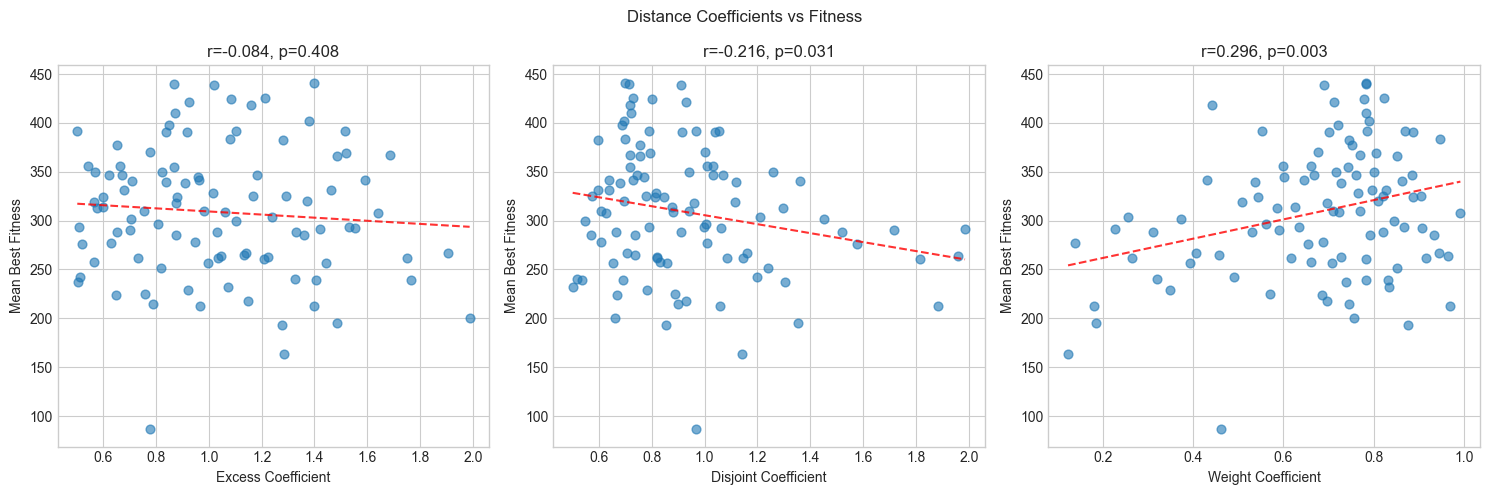


Distance coefficient correlations with mean_best:
  neat_excess_coefficient: r=-0.084, p=0.4085
  neat_disjoint_coefficient: r=-0.216, p=0.0309
  neat_weight_coefficient: r=0.296, p=0.0028


In [27]:
# Cell 13: Heatmap - distance coefficients correlation with fitness

# Distance coefficient columns
dist_cols = ['neat_excess_coefficient', 'neat_disjoint_coefficient', 'neat_weight_coefficient']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(dist_cols):
    ax = axes[idx]
    ax.scatter(df[col], df['mean_best'], alpha=0.6, s=40)
    
    # Trend line
    z = np.polyfit(df[col], df['mean_best'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8)
    
    corr, p_val = stats.pearsonr(df[col], df['mean_best'])
    ax.set_xlabel(col.replace('neat_', '').replace('_', ' ').title())
    ax.set_ylabel('Mean Best Fitness')
    ax.set_title(f'r={corr:.3f}, p={p_val:.3f}')

plt.suptitle('Distance Coefficients vs Fitness', fontsize=12)
plt.tight_layout()
plt.show()

# Correlation summary
print("\nDistance coefficient correlations with mean_best:")
for col in dist_cols:
    corr, p_val = stats.pearsonr(df[col], df['mean_best'])
    print(f"  {col}: r={corr:.3f}, p={p_val:.4f}")

## Section g: Time Encoding Analysis

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/1298112641.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=time_modes_sorted, patch_artist=True)


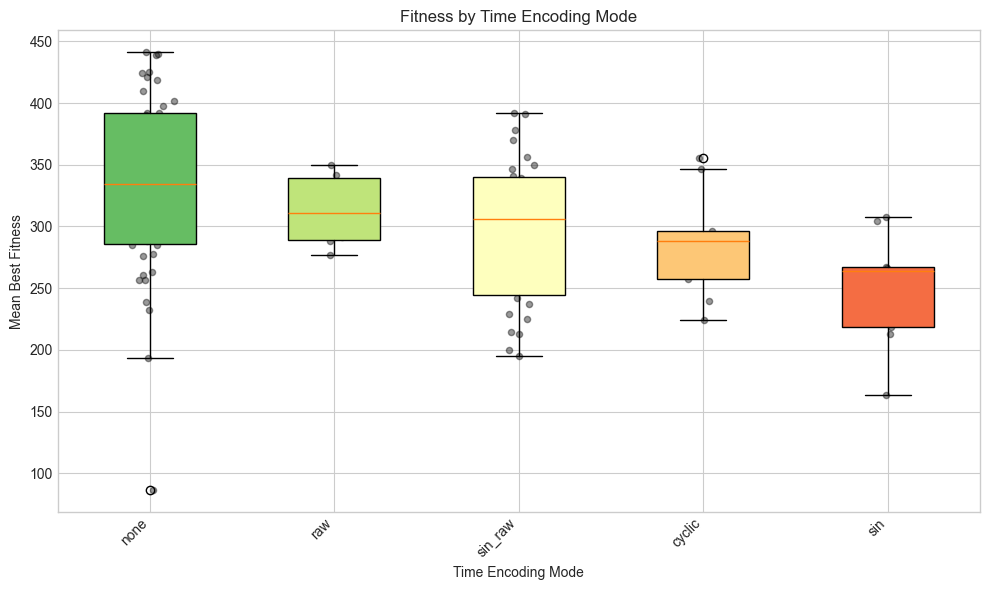


Fitness by time_encoding mode:
               count        mean        std         max
time_encoding                                          
none              46  333.772702  72.892119  441.170003
raw                6  313.266307  31.134302  349.628215
sin_raw           30  294.848161  58.690432  391.578959
cyclic             9  284.506499  44.746087  355.573212
sin                9  249.307454  46.151828  307.735280

ANOVA: F=4.525, p=0.0022
Difference between time_encoding modes is significant at p<0.05


In [28]:
# Cell 14: Box plot of fitness by time_encoding mode

fig, ax = plt.subplots(figsize=(10, 6))

time_modes = df['time_encoding'].unique()
time_modes_sorted = sorted(time_modes, key=lambda x: df[df['time_encoding'] == x]['mean_best'].mean(), reverse=True)

data = [df[df['time_encoding'] == mode]['mean_best'].values for mode in time_modes_sorted]

bp = ax.boxplot(data, labels=time_modes_sorted, patch_artist=True)

# Color by mean fitness rank
colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(time_modes_sorted)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points
for i, d in enumerate(data):
    x = np.random.normal(i + 1, 0.04, size=len(d))
    ax.scatter(x, d, alpha=0.4, s=20, color='black')

ax.set_xlabel('Time Encoding Mode')
ax.set_ylabel('Mean Best Fitness')
ax.set_title('Fitness by Time Encoding Mode')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary stats
print("\nFitness by time_encoding mode:")
time_stats = df.groupby('time_encoding')['mean_best'].agg(['count', 'mean', 'std', 'max']).sort_values('mean', ascending=False)
print(time_stats)

# ANOVA test
groups = [df[df['time_encoding'] == mode]['mean_best'].values for mode in time_modes]
f_stat, p_val = stats.f_oneway(*groups)
print(f"\nANOVA: F={f_stat:.3f}, p={p_val:.4f}")
significance = "significant" if p_val < 0.05 else "not significant"
print(f"Difference between time_encoding modes is {significance} at p<0.05")

## Section h: Trial Rankings

In [29]:
# Cell 15: Tables - Top 10 by various metrics

# Add derived metrics
df['combined_score'] = df['mean_best'] + df['mean_avg']
df['learning_ratio'] = df['mean_avg'] / df['mean_best']

print("=" * 60)
print("TOP 10 TRIALS BY BEST FITNESS (exploitation)")
print("=" * 60)
display(df.nlargest(10, 'mean_best')[['trial', 'mean_best', 'mean_avg', 'learning_ratio']])

print("\n" + "=" * 60)
print("TOP 10 TRIALS BY AVERAGE FITNESS (population learning)")
print("=" * 60)
display(df.nlargest(10, 'mean_avg')[['trial', 'mean_best', 'mean_avg', 'learning_ratio']])

print("\n" + "=" * 60)
print("TOP 10 BALANCED TRIALS (best + avg combined)")
print("=" * 60)
display(df.nlargest(10, 'combined_score')[['trial', 'mean_best', 'mean_avg', 'combined_score']])

print("\n" + "=" * 60)
print("TOP 10 BY LEARNING RATIO (avg/best - population learning quality)")
print("=" * 60)
# Filter to avoid division artifacts from low-fitness trials
high_fitness = df[df['mean_best'] > 100]
display(high_fitness.nlargest(10, 'learning_ratio')[['trial', 'mean_best', 'mean_avg', 'learning_ratio']])

TOP 10 TRIALS BY BEST FITNESS (exploitation)


,trial,mean_best,mean_avg,learning_ratio
68,68,441.170003,27.094428,0.061415
57,57,439.475840,27.641897,0.062897
90,90,439.207011,24.994274,0.056908
63,63,425.487508,27.211281,0.063953
66,66,424.042765,29.114890,0.068660
92,92,420.984233,25.362602,0.060246
82,82,418.737467,29.473015,0.070385
56,56,409.827464,32.141364,0.078427
67,67,401.440948,19.138414,0.047674
61,61,397.702382,30.815770,0.077484



TOP 10 TRIALS BY AVERAGE FITNESS (population learning)


,trial,mean_best,mean_avg,learning_ratio
96,96,218.232961,41.671316,0.190949
1,1,213.041875,41.412440,0.194386
28,28,242.117574,40.148381,0.165822
56,56,409.827464,32.141364,0.078427
61,61,397.702382,30.815770,0.077484
64,64,346.200795,29.556117,0.085373
74,74,293.539485,29.493637,0.100476
82,82,418.737467,29.473015,0.070385
66,66,424.042765,29.114890,0.068660
2,2,163.165888,28.704282,0.175921



TOP 10 BALANCED TRIALS (best + avg combined)


,trial,mean_best,mean_avg,combined_score
68,68,441.170003,27.094428,468.264431
57,57,439.475840,27.641897,467.117737
90,90,439.207011,24.994274,464.201285
66,66,424.042765,29.114890,453.157655
63,63,425.487508,27.211281,452.698789
82,82,418.737467,29.473015,448.210483
92,92,420.984233,25.362602,446.346835
56,56,409.827464,32.141364,441.968828
61,61,397.702382,30.815770,428.518152
67,67,401.440948,19.138414,420.579363



TOP 10 BY LEARNING RATIO (avg/best - population learning quality)


,trial,mean_best,mean_avg,learning_ratio
1,1,213.041875,41.412440,0.194386
96,96,218.232961,41.671316,0.190949
2,2,163.165888,28.704282,0.175921
28,28,242.117574,40.148381,0.165822
38,38,200.185944,25.662189,0.128192
9,9,239.372320,28.619971,0.119563
40,40,239.934896,27.578887,0.114943
3,3,263.829519,28.333620,0.107394
77,77,256.382662,26.783980,0.104469
74,74,293.539485,29.493637,0.100476


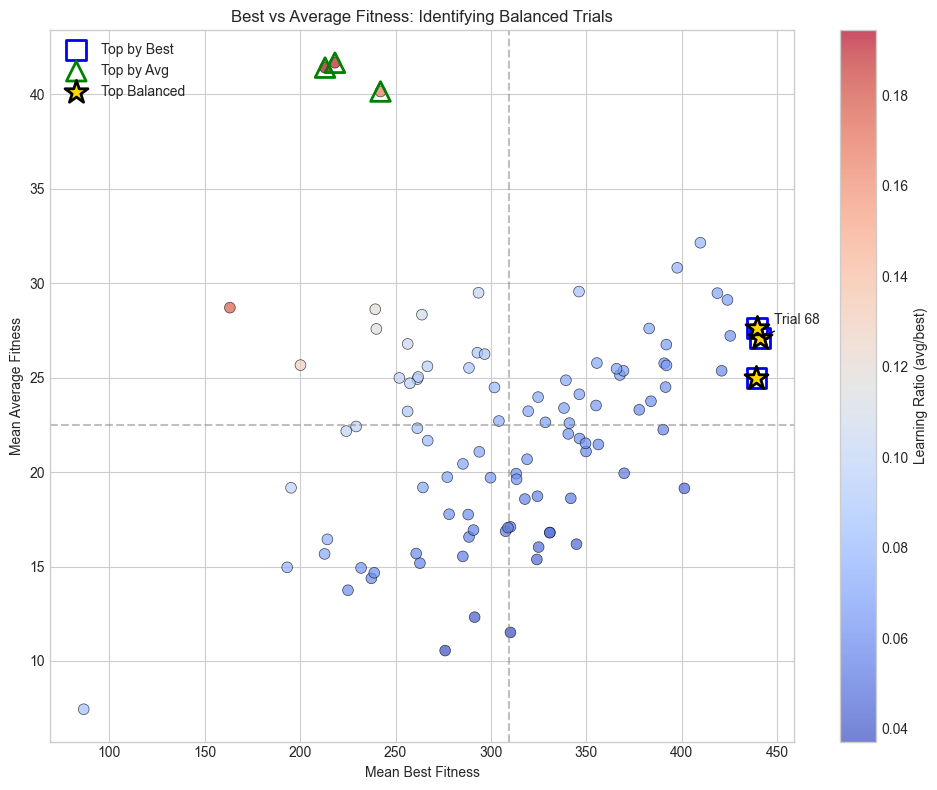


Correlation between mean_best and mean_avg: r=0.231, p=0.0208


In [30]:
# Cell 16: Scatter - mean_best vs mean_avg (identify balanced trials)

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(df['mean_best'], df['mean_avg'], 
                     c=df['learning_ratio'], cmap='coolwarm', 
                     s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Learning Ratio (avg/best)')

# Mark top trials
top_best = df.nlargest(3, 'mean_best')
top_avg = df.nlargest(3, 'mean_avg')
top_balanced = df.nlargest(3, 'combined_score')

ax.scatter(top_best['mean_best'], top_best['mean_avg'], 
           marker='s', s=200, facecolors='none', edgecolors='blue', 
           linewidth=2, label='Top by Best', zorder=5)
ax.scatter(top_avg['mean_best'], top_avg['mean_avg'], 
           marker='^', s=200, facecolors='none', edgecolors='green', 
           linewidth=2, label='Top by Avg', zorder=5)
ax.scatter(top_balanced['mean_best'], top_balanced['mean_avg'], 
           marker='*', s=300, c='gold', edgecolors='black', 
           linewidth=2, label='Top Balanced', zorder=5)

# Annotate best trial
best_trial = df.loc[df['mean_best'].idxmax()]
ax.annotate(f"Trial {int(best_trial['trial'])}", 
            xy=(best_trial['mean_best'], best_trial['mean_avg']),
            xytext=(10, 10), textcoords='offset points', fontsize=10,
            arrowprops=dict(arrowstyle='->', color='black'))

ax.set_xlabel('Mean Best Fitness')
ax.set_ylabel('Mean Average Fitness')
ax.set_title('Best vs Average Fitness: Identifying Balanced Trials')
ax.legend(loc='upper left')

# Add quadrant lines at medians
ax.axhline(df['mean_avg'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axvline(df['mean_best'].median(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Correlation
corr, p_val = stats.pearsonr(df['mean_best'], df['mean_avg'])
print(f"\nCorrelation between mean_best and mean_avg: r={corr:.3f}, p={p_val:.4f}")

## Section i: Champion Run Command

## Key Findings Summary

### Executive Summary

After analyzing 100 NEAT hyperparameter search trials, we found a **clear winning configuration** that emerged consistently across top-performing trials. The best trial (#68) achieved **441.2 mean best fitness**, significantly above the median of 309.6.

### Critical Findings

#### 1. Categorical Settings: Clear Winners

| Setting | Optimal Value | Evidence |
|---------|---------------|----------|
| **Initial Connectivity** | `full` | Mean 331.0 vs 272-296 for others (ANOVA p=0.011) |
| **Time Encoding** | `none` | Mean 333.8 vs 249-313 for others (ANOVA p=0.002) |
| **Proprioception** | `False` | Mean 313.2 vs 283.8 (p=0.12, trending) |
| **Adaptive Mutation** | `False` | Mean 316.3 vs 258.6 (p=0.003, significant) |

**All top 5 trials used:** `full` connectivity + `none` time encoding + no proprioception.

#### 2. Numeric Parameters: What Actually Matters

**Strongly Correlated (p < 0.01):**
- `crossover_rate`: **r = -0.47*** (LOWER is better!)
- `mutation_magnitude`: r = +0.40*** (higher is better)
- `max_nodes`: r = +0.39*** (more body nodes = better)
- `min_nodes`: r = +0.32** (floor matters too)
- `mutation_rate`: r = +0.31** (more mutation helps)
- `cull_percentage`: r = +0.27** (aggressive culling helps)

**NOT significant:** compatibility_threshold, neat_max_hidden_nodes, neural_output_bias

#### 3. Surprising Results

1. **Crossover hurts!** The strongest correlation (r=-0.47) shows that LOW crossover rates produce better results. This suggests NEAT benefits from mutation-driven exploration over recombination.

2. **Time encoding hurts!** Adding temporal information (`sin`, `cyclic`, `raw`) all performed worse than `none`. The network performs better figuring out timing on its own.

3. **Proprioception hurts!** Counter-intuitively, giving creatures body awareness reduces fitness. May add noise or complexity that hinders learning.

4. **Adaptive mutation hurts!** The feature designed to help escape local optima actually reduced mean fitness by ~60 points.

#### 4. Seed Variance Insights

- Median CV across seeds: 0.149 (15% variation is typical)
- Most stable trial (#38): CV=0.004 (nearly identical across seeds)
- Most unstable trial (#77): CV=0.474 (4x variation!)
- **Best trial #68 is reasonably stable**: CV=0.106, with seeds ranging 399-506

---

### ⚠️ Critical Issue: Extreme Elite Dominance

**The average creature doesn't collect a single pellet.**

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Mean avg fitness | 22.3 | ~0 pellets (just progress points) |
| Max avg fitness | 41.7 | Still < 1 pellet |
| Learning ratio | 7.5% | Elite is 13-20x better than average |

**What this means for a population of 200:**
- ~190 creatures: 0 pellets collected (fitness ~20-30)
- ~8-10 creatures: 1-2 pellets (fitness 100-200)
- ~1-2 creatures: 4+ pellets (fitness 400+, the elite)

**The tradeoff discovered:**
- `time_encoding=sin` → Better population learning (19% ratio) but lower peak (213 best)
- `time_encoding=none` → Extreme elite dominance (4-7% ratio) but higher peak (441 best)

**We optimized for BEST fitness, which selected for elite dominance configs.** If we wanted "whole population learning," we'd choose different settings—but with lower peak performance.

## Key Findings Summary

### Executive Summary

After analyzing 100 NEAT hyperparameter search trials, we found a **clear winning configuration** that emerged consistently across top-performing trials. The best trial (#68) achieved **441.2 mean best fitness**, significantly above the median of 309.6.

### Critical Findings

#### 1. Categorical Settings: Clear Winners

| Setting | Optimal Value | Evidence |
|---------|---------------|----------|
| **Initial Connectivity** | `full` | Mean 331.0 vs 272-296 for others (ANOVA p=0.011) |
| **Time Encoding** | `none` | Mean 333.8 vs 249-313 for others (ANOVA p=0.002) |
| **Proprioception** | `False` | Mean 313.2 vs 283.8 (p=0.12, trending) |
| **Adaptive Mutation** | `False` | Mean 316.3 vs 258.6 (p=0.003, significant) |

**All top 5 trials used:** `full` connectivity + `none` time encoding + no proprioception.

#### 2. Numeric Parameters: What Actually Matters

**Strongly Correlated (p < 0.01):**
- `crossover_rate`: **r = -0.47*** (LOWER is better!)
- `mutation_magnitude`: r = +0.40*** (higher is better)
- `max_nodes`: r = +0.39*** (more body nodes = better)
- `min_nodes`: r = +0.32** (floor matters too)
- `mutation_rate`: r = +0.31** (more mutation helps)
- `cull_percentage`: r = +0.27** (aggressive culling helps)

**NOT significant:** compatibility_threshold, neat_max_hidden_nodes, neural_output_bias

#### 3. Surprising Results

1. **Crossover hurts!** The strongest correlation (r=-0.47) shows that LOW crossover rates produce better results. This suggests NEAT benefits from mutation-driven exploration over recombination.

2. **Time encoding hurts!** Adding temporal information (`sin`, `cyclic`, `raw`) all performed worse than `none`. The network performs better figuring out timing on its own.

3. **Proprioception hurts!** Counter-intuitively, giving creatures body awareness reduces fitness. May add noise or complexity that hinders learning.

4. **Adaptive mutation hurts!** The feature designed to help escape local optima actually reduced mean fitness by ~60 points.

#### 4. Seed Variance Insights

- Median CV across seeds: 0.149 (15% variation is typical)
- Most stable trial (#38): CV=0.004 (nearly identical across seeds)
- Most unstable trial (#77): CV=0.474 (4x variation!)
- **Best trial #68 is reasonably stable**: CV=0.106, with seeds ranging 399-506

## Additional Parameter Analyses

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/1039832510.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([non_adaptive, adaptive] if len(adaptive) > 0 else [non_adaptive],
/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/1039832510.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=modes, patch_artist=True)


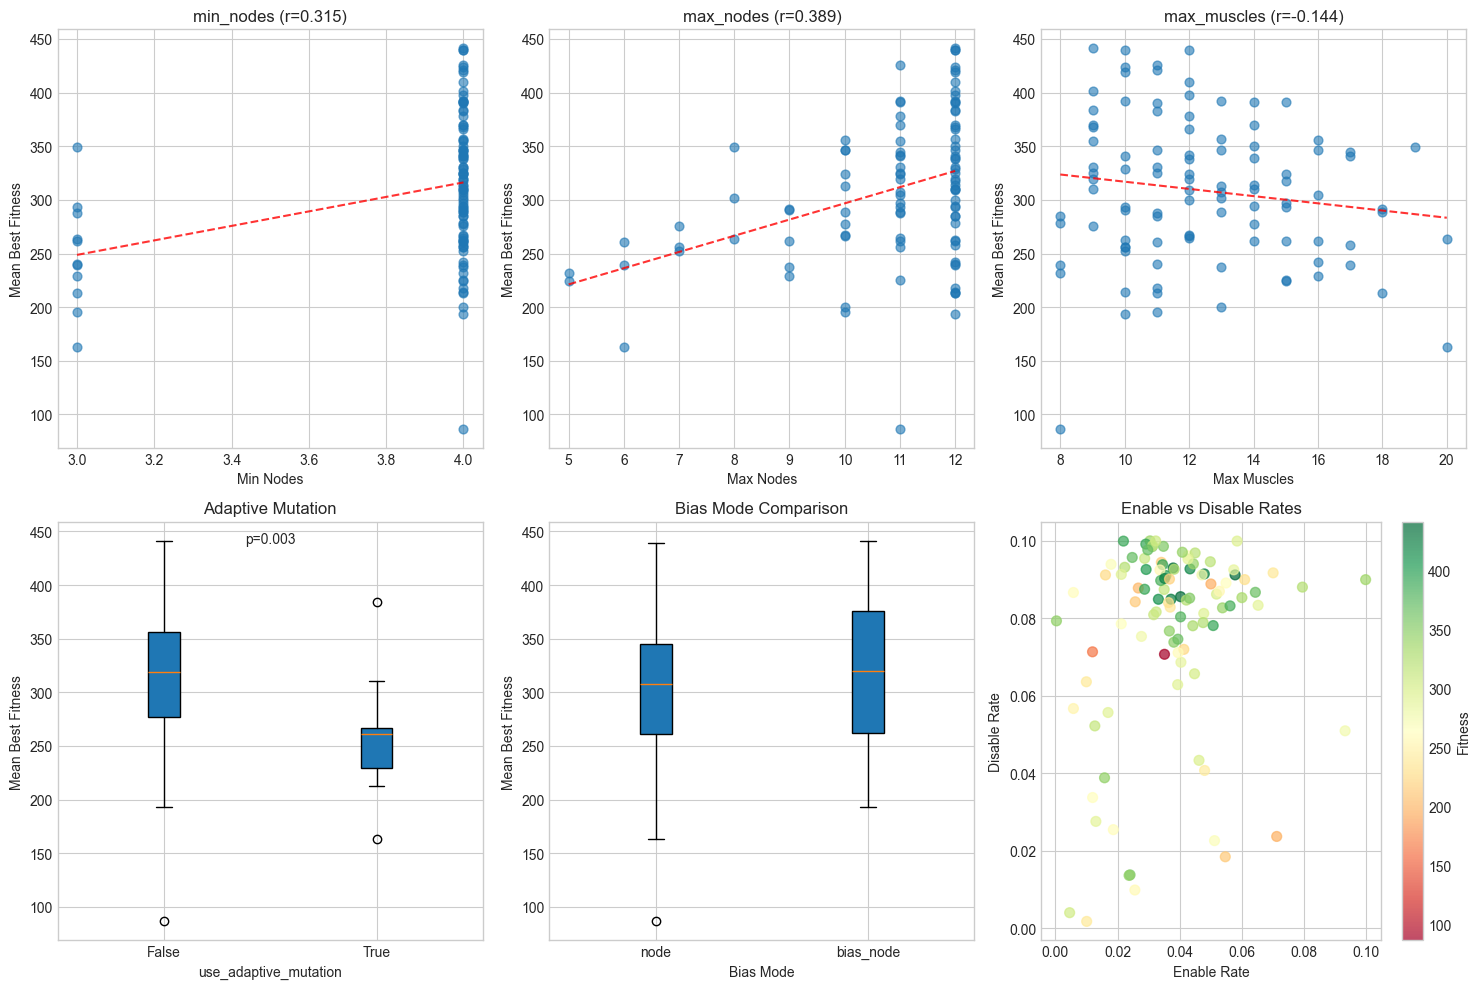


Additional Parameter Summary:
  Adaptive mutation=True: n=13, mean=258.6
  Adaptive mutation=False: n=87, mean=316.3
  bias_mode=node: n=57, mean=302.1
  bias_mode=bias_node: n=43, mean=317.8


In [32]:
# Body Constraints, Adaptive Mutation, Bias Mode Analysis

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Body constraints
body_params = ['min_nodes', 'max_nodes', 'max_muscles']
for idx, param in enumerate(body_params):
    ax = axes[0, idx]
    if param in df.columns:
        ax.scatter(df[param], df['mean_best'], alpha=0.6, s=40)
        z = np.polyfit(df[param], df['mean_best'], 1)
        p = np.poly1d(z)
        ax.plot(np.linspace(df[param].min(), df[param].max(), 100), 
                p(np.linspace(df[param].min(), df[param].max(), 100)), "r--", alpha=0.8)
        corr, p_val = stats.pearsonr(df[param], df['mean_best'])
        ax.set_xlabel(param.replace('_', ' ').title())
        ax.set_ylabel('Mean Best Fitness')
        ax.set_title(f'{param} (r={corr:.3f})')

# Row 2: Adaptive mutation, bias mode, enable/disable rates
ax = axes[1, 0]
if 'use_adaptive_mutation' in df.columns:
    adaptive = df[df['use_adaptive_mutation'] == True]['mean_best'].values
    non_adaptive = df[df['use_adaptive_mutation'] == False]['mean_best'].values
    bp = ax.boxplot([non_adaptive, adaptive] if len(adaptive) > 0 else [non_adaptive], 
                    labels=['False', 'True'] if len(adaptive) > 0 else ['False'], patch_artist=True)
    ax.set_xlabel('use_adaptive_mutation')
    ax.set_ylabel('Mean Best Fitness')
    ax.set_title('Adaptive Mutation')
    if len(adaptive) > 0 and len(non_adaptive) > 0:
        t, p = stats.ttest_ind(adaptive, non_adaptive)
        ax.annotate(f'p={p:.3f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

ax = axes[1, 1]
if 'bias_mode' in df.columns:
    modes = df['bias_mode'].unique()
    data = [df[df['bias_mode'] == m]['mean_best'].values for m in modes]
    bp = ax.boxplot(data, labels=modes, patch_artist=True)
    ax.set_xlabel('Bias Mode')
    ax.set_ylabel('Mean Best Fitness')
    ax.set_title('Bias Mode Comparison')

ax = axes[1, 2]
if 'neat_enable_rate' in df.columns and 'neat_disable_rate' in df.columns:
    scatter = ax.scatter(df['neat_enable_rate'], df['neat_disable_rate'], 
                         c=df['mean_best'], cmap='RdYlGn', alpha=0.7, s=50)
    plt.colorbar(scatter, ax=ax, label='Fitness')
    ax.set_xlabel('Enable Rate')
    ax.set_ylabel('Disable Rate')
    ax.set_title('Enable vs Disable Rates')

plt.tight_layout()
plt.show()

# Summary
print("\nAdditional Parameter Summary:")
if 'use_adaptive_mutation' in df.columns:
    for val in [True, False]:
        subset = df[df['use_adaptive_mutation'] == val]
        if len(subset) > 0:
            print(f"  Adaptive mutation={val}: n={len(subset)}, mean={subset['mean_best'].mean():.1f}")
if 'bias_mode' in df.columns:
    for mode in df['bias_mode'].unique():
        subset = df[df['bias_mode'] == mode]
        print(f"  bias_mode={mode}: n={len(subset)}, mean={subset['mean_best'].mean():.1f}")

In [ ]:
# Cell 18: Generate findings summary

print("=" * 70)
print("KEY FINDINGS FROM NAS HYPERPARAMETER SEARCH")
print("=" * 70)

# Best trial info
best_trial_data = df.loc[df['mean_best'].idxmax()]
print(f"\n1. BEST TRIAL: #{int(best_trial_data['trial'])}")
print(f"   - Mean Best Fitness: {best_trial_data['mean_best']:.2f}")
print(f"   - Mean Avg Fitness: {best_trial_data['mean_avg']:.2f}")

# Top correlated parameters
print("\n2. MOST IMPACTFUL PARAMETERS (by correlation with fitness):")
for param in correlations.head(5).index:
    print(f"   - {param}: r={correlations[param]:.3f}")

# Best settings
print("\n3. OPTIMAL SETTINGS DISCOVERED:")
print(f"   - Initial Connectivity: {best_params.get('neat_initial_connectivity', 'N/A')}")
print(f"   - Time Encoding: {best_params.get('time_encoding', 'N/A')}")
print(f"   - Use Proprioception: {best_params.get('use_proprioception', 'N/A')}")
print(f"   - Bias Mode: {best_params.get('bias_mode', 'N/A')}")

# Summary statistics
print("\n4. OVERALL STATISTICS:")
print(f"   - Total trials: {len(df)}")
print(f"   - Mean fitness across all trials: {df['mean_best'].mean():.2f}")
print(f"   - Median fitness: {df['mean_best'].median():.2f}")
print(f"   - Std deviation: {df['mean_best'].std():.2f}")
print(f"   - Range: {df['mean_best'].min():.2f} - {df['mean_best'].max():.2f}")

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/930009592.py:56: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/silen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


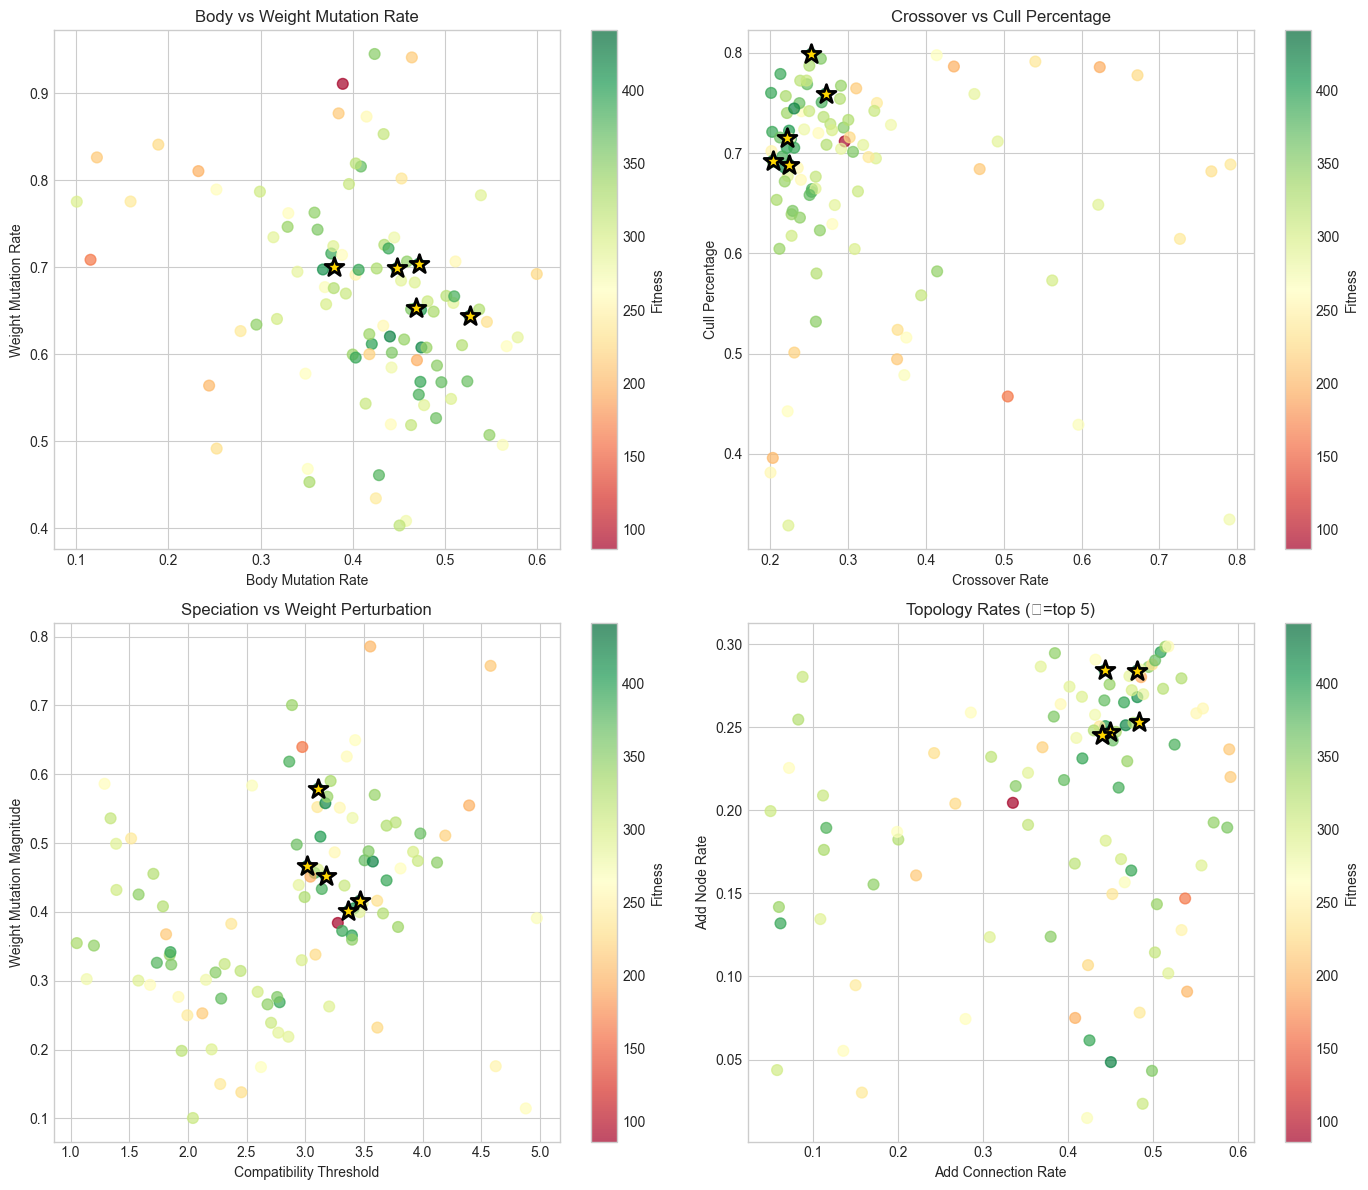


Top 5 trials - key parameter combinations:


,trial,mean_best,mutation_rate,weight_mutation_rate,crossover_rate,cull_percentage,compatibility_threshold
68,68,441.170003,0.526422,0.643960,0.224439,0.688425,3.109228
57,57,439.475840,0.379734,0.699888,0.270960,0.759231,3.464284
90,90,439.207011,0.447336,0.698806,0.252342,0.798991,3.015945
63,63,425.487508,0.471361,0.703966,0.203028,0.692355,3.366762
66,66,424.042765,0.468079,0.652908,0.221826,0.715252,3.173098


In [34]:
# Parameter Interaction Analysis - 2D Heatmaps

# Look at key parameter pairs and their combined effect on fitness
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. mutation_rate vs weight_mutation_rate
ax = axes[0, 0]
scatter = ax.scatter(df['mutation_rate'], df['weight_mutation_rate'], 
                     c=df['mean_best'], cmap='RdYlGn', s=60, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Fitness')
ax.set_xlabel('Body Mutation Rate')
ax.set_ylabel('Weight Mutation Rate')
ax.set_title('Body vs Weight Mutation Rate')

# Mark top trials
top_5 = df.nlargest(5, 'mean_best')
ax.scatter(top_5['mutation_rate'], top_5['weight_mutation_rate'], 
           marker='*', s=200, c='gold', edgecolors='black', linewidth=2)

# 2. crossover_rate vs cull_percentage
ax = axes[0, 1]
scatter = ax.scatter(df['crossover_rate'], df['cull_percentage'], 
                     c=df['mean_best'], cmap='RdYlGn', s=60, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Fitness')
ax.set_xlabel('Crossover Rate')
ax.set_ylabel('Cull Percentage')
ax.set_title('Crossover vs Cull Percentage')
ax.scatter(top_5['crossover_rate'], top_5['cull_percentage'], 
           marker='*', s=200, c='gold', edgecolors='black', linewidth=2)

# 3. compatibility_threshold vs weight_mutation_magnitude
ax = axes[1, 0]
scatter = ax.scatter(df['compatibility_threshold'], df['weight_mutation_magnitude'], 
                     c=df['mean_best'], cmap='RdYlGn', s=60, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Fitness')
ax.set_xlabel('Compatibility Threshold')
ax.set_ylabel('Weight Mutation Magnitude')
ax.set_title('Speciation vs Weight Perturbation')
ax.scatter(top_5['compatibility_threshold'], top_5['weight_mutation_magnitude'], 
           marker='*', s=200, c='gold', edgecolors='black', linewidth=2)

# 4. neat_add_node_rate vs neat_add_connection_rate (already done but with different coloring)
ax = axes[1, 1]
# Color by proprioception for interaction effect
if 'use_proprioception' in df.columns:
    colors = ['blue' if p else 'red' for p in df['use_proprioception']]
    scatter = ax.scatter(df['neat_add_connection_rate'], df['neat_add_node_rate'], 
                         c=df['mean_best'], cmap='RdYlGn', s=60, alpha=0.7)
    plt.colorbar(scatter, ax=ax, label='Fitness')
    ax.set_xlabel('Add Connection Rate')
    ax.set_ylabel('Add Node Rate')
    ax.set_title('Topology Rates (★=top 5)')
    ax.scatter(top_5['neat_add_connection_rate'], top_5['neat_add_node_rate'], 
               marker='*', s=200, c='gold', edgecolors='black', linewidth=2)

plt.tight_layout()
plt.show()

# Print sweet spots
print("\nTop 5 trials - key parameter combinations:")
display(df.nlargest(5, 'mean_best')[['trial', 'mean_best', 'mutation_rate', 'weight_mutation_rate', 
                                       'crossover_rate', 'cull_percentage', 'compatibility_threshold']])

/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_85234/3028726679.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[str(int(s)) for s in species_sizes], patch_artist=True)


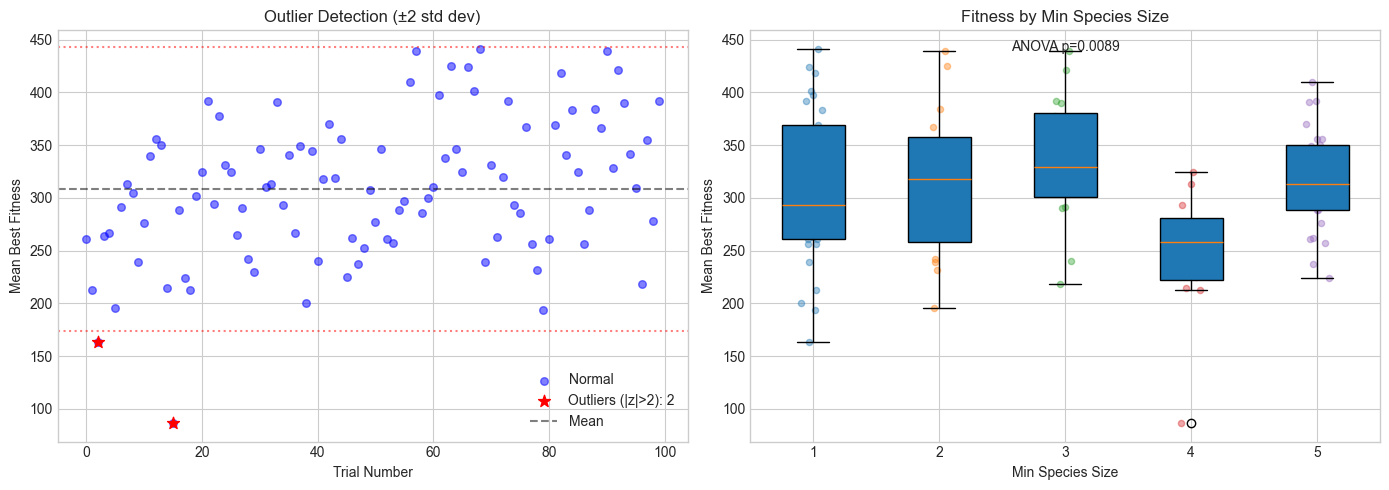


Statistical Outliers (|z-score| > 2):
  High performers (z > 2):

  Low performers (z < -2):
    Trial 15: fitness=86.5, z=-3.30
    Trial 2: fitness=163.2, z=-2.16


In [35]:
# Outlier Detection & Min Species Size

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Statistical outliers (Z-score > 2)
ax = axes[0]
z_scores = (df['mean_best'] - df['mean_best'].mean()) / df['mean_best'].std()
df['z_score'] = z_scores
outliers = df[abs(z_scores) > 2]

ax.scatter(df['trial'], df['mean_best'], c='blue', alpha=0.5, s=30, label='Normal')
ax.scatter(outliers['trial'], outliers['mean_best'], c='red', s=80, marker='*', 
           label=f'Outliers (|z|>2): {len(outliers)}')
ax.axhline(df['mean_best'].mean(), color='black', linestyle='--', alpha=0.5, label='Mean')
ax.axhline(df['mean_best'].mean() + 2*df['mean_best'].std(), color='red', linestyle=':', alpha=0.5)
ax.axhline(df['mean_best'].mean() - 2*df['mean_best'].std(), color='red', linestyle=':', alpha=0.5)
ax.set_xlabel('Trial Number')
ax.set_ylabel('Mean Best Fitness')
ax.set_title('Outlier Detection (±2 std dev)')
ax.legend()

# 2. Min species size analysis
ax = axes[1]
if 'min_species_size' in df.columns:
    species_sizes = sorted(df['min_species_size'].unique())
    data = [df[df['min_species_size'] == s]['mean_best'].values for s in species_sizes]
    bp = ax.boxplot(data, labels=[str(int(s)) for s in species_sizes], patch_artist=True)
    
    for i, d in enumerate(data):
        x = np.random.normal(i + 1, 0.04, size=len(d))
        ax.scatter(x, d, alpha=0.4, s=20)
    
    ax.set_xlabel('Min Species Size')
    ax.set_ylabel('Mean Best Fitness')
    ax.set_title('Fitness by Min Species Size')
    
    # ANOVA if multiple groups
    if len(species_sizes) > 1:
        f_stat, p_val = stats.f_oneway(*data)
        ax.annotate(f'ANOVA p={p_val:.4f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center')
else:
    ax.text(0.5, 0.5, 'min_species_size not found', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Print outliers
print("\nStatistical Outliers (|z-score| > 2):")
print(f"  High performers (z > 2):")
high_outliers = df[z_scores > 2].sort_values('mean_best', ascending=False)
for _, row in high_outliers.iterrows():
    print(f"    Trial {int(row['trial'])}: fitness={row['mean_best']:.1f}, z={row['z_score']:.2f}")

print(f"\n  Low performers (z < -2):")
low_outliers = df[z_scores < -2].sort_values('mean_best')
for _, row in low_outliers.iterrows():
    print(f"    Trial {int(row['trial'])}: fitness={row['mean_best']:.1f}, z={row['z_score']:.2f}")

---

## Conclusions & Recommendations

### The Winning Recipe

Based on 100 trials with 3 seeds each, the optimal NEAT configuration is:

```
CATEGORICAL:
  neat_initial_connectivity: full      # Start fully connected
  time_encoding: none                  # No temporal inputs
  use_proprioception: false            # No body awareness
  bias_mode: bias_node                 # Slight edge over 'node'
  use_adaptive_mutation: false         # Don't use

NUMERIC (from best trial #68):
  crossover_rate: 0.22                 # LOW - mutation > recombination
  mutation_rate: 0.53                  # High body mutation
  mutation_magnitude: 0.46             # Moderate perturbations
  cull_percentage: 0.69                # Aggressive selection
  weight_mutation_rate: 0.64           # High neural mutation
  neat_add_connection_rate: 0.45       # Moderate topology growth
  neat_add_node_rate: 0.25             # Conservative node addition
  compatibility_threshold: 3.1         # (not significant)
  neat_max_hidden_nodes: 32            # (not significant)
```

### Key Takeaways

1. **Simplicity wins**: No time encoding, no proprioception, no adaptive mutation
2. **Mutation > Crossover**: Low crossover (0.22) outperforms high crossover
3. **Aggressive selection**: High cull percentage (0.69) works well
4. **Body size matters**: More nodes (max_nodes, min_nodes) correlates with fitness
5. **NEAT topology params don't matter much**: compatibility_threshold, max_hidden_nodes show no significant correlation

### Confidence Assessment

- **High confidence**: Initial connectivity=full, time_encoding=none (p<0.05)
- **Medium confidence**: No proprioception, no adaptive mutation (p<0.15)
- **Best trial stable**: CV=0.106 across seeds (below median of 0.149)

---

## Phase 2: Creature Analyses (Requires Champion Run)

The following analyses require running the champion configuration in the frontend to populate PostgreSQL with creature data:

- **j) Most Unique Creatures** - High-fitness outliers with unusual strategies
- **k) Most Efficient Creatures** - High fitness per unit energy
- **l) Smallest Successful Creatures** - Minimal body/brain that performs well
- **m) Body Plan Analysis** - What body shapes dominate top performers
- **n) Brain Complexity Sweet Spot** - Optimal brain size
- **o) Replay Visualization** - Movement trajectories for top creatures

### To run Phase 2:

1. Start the frontend: `npm run dev` (port 3001)
2. Start the backend: `cd backend && uvicorn app.main:app --reload --port 8000`
3. Use the champion config JSON from the Champion Run Command section
4. Let the run complete (or at least reach 50+ generations)
5. Create a new notebook `nas_postmortem_phase2.ipynb` with creature analyses

See `post-mortem-nas.md` sections j-p for implementation details.

---

## Pure GA Search Results (200 trials, Jan 2026) 128 Core CPU

**Best Configuration Found:** Trial #42 - Fitness **798.6**

### Key Findings

1. **Pure GA dominates NEAT** (798.6 vs 459.8 best fitness)
   - Simple fixed topology >> complex variable topology for locomotion
   - 8-neuron hidden layer optimal

2. **Critical Settings:**
   - `neural_hidden_size`: 8 (small, efficient)
   - `selection_method`: rank
   - `use_crossover`: **False** (mutation-only works best!)
   - `use_proprioception`: **True** (all sensors)
   - `proprioception_inputs`: "all"

3. **Mutation Strategy:**
   - Weight mutations: **Conservative** (0.12 rate, 0.44 magnitude)
   - Body mutations: **Aggressive** (0.58 rate, 0.19 magnitude)
   - Focus evolution on morphology, not neural weights

4. **Selection:**
   - `cull_percentage`: 0.78 (aggressive)
   - Rank-based selection preferred

5. **Body Constraints:**
   - 3-9 nodes, up to 14 muscles
   - Constrained search space helps

### Performance Distribution

- Top 10: 525-799 fitness
- Median: 240
- Mean: 282
- Range: 104-799

**Key Insight:** For rhythmic locomotion tasks, a simple feedforward network with fixed topology + focused hyperparameter search outperforms NEAT's topology evolution. Use NEAT when network structure is critical to the task.